# Practical Data Science - Assignment 3

---
# Toxic Span Detection

## Student Name: Katsmpalos Ilias

The current notebook has been put together on google colab, due to the absence of local computanional power. Please open it on colab and enable the GPU if you want to run it in order to have a smoother eperience. In case you need to access the original notebook on colab and create a copy from there, please visit [this link](https://colab.research.google.com/drive/1z0N4bmB7aEHejjkjnwf-R2c4UtxuEXSu?usp=sharing)

In [ ]:
from ast import literal_eval
import pandas as pd
import numpy as np
import csv

# 1. Get the data

## Clone Repo

We will clone a fork of the original github repo  https://github.com/ipavlopoulos/toxic_spans.git by contributors [ipavlopoulos](https://github.com/ipavlopoulos), [sorensenjs](https://github.com/sorensenjs), [LeoLaugier](https://github.com/LeoLaugier)

This repo contains the relevant datasets for the toxic span detection. Additionally, I have created a [branch](https://github.com/iliasKatsabalos/toxic_spans/commit/c0e0ae74d54f47ed2d256d4d974b40ce05cb7826) commiting a small adjustment in the `models.py` file, enabling the functionality for using pretrained embeddings. 

In [1]:
!git clone https://github.com/iliasKatsabalos/toxic_spans.git
!cd toxic_spans && git checkout pretrained_embeddings

Cloning into 'toxic_spans'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 304 (delta 17), reused 28 (delta 10), pack-reused 268
Receiving objects: 100% (304/304), 1.15 MiB | 17.03 MiB/s, done.
Resolving deltas: 100% (147/147), done.
Branch 'pretrained_embeddings' set up to track remote branch 'pretrained_embeddings' from 'origin'.
Switched to a new branch 'pretrained_embeddings'


In [ ]:
train = pd.read_csv("toxic_spans/data/tsd_train.csv")
trial = pd.read_csv("toxic_spans/data/tsd_trial.csv")
train.spans = train.spans.apply(literal_eval)
trial.spans = trial.spans.apply(literal_eval)
train.sample(5)

,spans,text
398,"[22, 23, 24, 25, 26, 27, 28, 29, 355, 356, 357...",Yes I got the similar warnings before. I usual...
3028,"[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...",How did this piece of crap get on TV?
277,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",Except Trump has no real idea about whats at s...
7544,"[45, 46, 47, 48, 49, 50, 51]",And I always thought that Eric Trump was the d...
1856,"[256, 257, 258, 259, 260, 261, 262, 434, 435, ...","Morneau is correct he doesn't ""report"" to jour..."


#2. Tokenization

An important part of our application is the tokenization process. For this reason, we should be very strict on how we handle tokenizers, as different tokenizers might produce different sets of tokens. Sometimes, even different methods of the same tokenizer might produce different number of tokens. For these reasons, we will work with the `TreebankWordTokenizer` and use the method `span_tokenize` in order to retrieve the spans of the tokens, as well as the tokens themselves in order to be consistent with the parsing.

In [ ]:
from nltk.tokenize import TreebankWordTokenizer as wst

def get_all_spans(text):
    '''
    retrieve the spans of tokens for every token in a text

    Parameters:
        text (str): the text that we want to parse
    Returns
        tokenizer.span_tokenize (list): returns a list of tuples with the token spans
    '''
    #bug with span tokenize https://github.com/nltk/nltk/issues/1750
    text = text.replace('"','?')
    tokenizer = wst()
    return tokenizer.span_tokenize(text)

def get_tokens(spans,text):
    '''
    Having retrieved the token spans of a text, retrieve the actual tokens
    
    Parameters:
        spans (list): list of tuples, first elemnt of the tuple being the beginning 
                        of s span, the second element the end of the span
        Returns:
        tokens (list): list of tokens
    '''
    tokens = []
    for span in spans:
        tokens.append(text[span[0]:span[1]])
    return tokens

#we will retrieve the spans of our data as well as the tokens
train['all_spans'] = train.text.apply(get_all_spans)
train['tokenized_text'] = train.apply(lambda x: get_tokens(x.all_spans, x.text), axis=1)
trial['all_spans'] = trial.text.apply(get_all_spans)
trial['tokenized_text'] = trial.apply(lambda x: get_tokens(x.all_spans, x.text), axis=1)

# 3. Exploratory Data analysis

Let's have a look at how many rows do we have in our train and trial sets

In [ ]:
print('Number of rows in train: {}, Number of rows in trial: {}'.format(len(train), len(trial)))

Number of rows in train: 7939, Number of rows in trial: 690


We then check for rows with empty spans.

In [ ]:
train[train.spans.str.len() == 0]

,spans,text,all_spans,tokenized_text
5,[],"But, but, but, is NOT a defense. It's not eve...","[(0, 3), (3, 4), (5, 8), (8, 9), (10, 13), (13...","[But, ,, but, ,, but, ,, is, NOT, a, defense.,..."
21,[],Jim\n\nI think Donald is a con man and a dange...,"[(0, 3), (5, 6), (7, 12), (13, 19), (20, 22), ...","[Jim, I, think, Donald, is, a, con, man, and, ..."
24,[],Exposing hypocrites like Trump and Pence is th...,"[(0, 8), (9, 19), (20, 24), (25, 30), (31, 34)...","[Exposing, hypocrites, like, Trump, and, Pence..."
27,[],"The malignant narcissist, mentally deranged so...","[(0, 3), (4, 13), (14, 24), (24, 25), (26, 34)...","[The, malignant, narcissist, ,, mentally, dera..."
60,[],"the is NO CONSENSUS you ignorant loser, NONE, ...","[(0, 3), (4, 6), (7, 9), (10, 19), (20, 23), (...","[the, is, NO, CONSENSUS, you, ignorant, loser,..."
...,...,...,...,...
7828,[],He is a scary maniac with a psychopath attitude.,"[(0, 2), (3, 5), (6, 7), (8, 13), (14, 20), (2...","[He, is, a, scary, maniac, with, a, psychopath..."
7837,[],"Sniffle, sniffle Ted Cruz proved tonight he's...","[(0, 7), (7, 8), (9, 16), (18, 21), (22, 26), ...","[Sniffle, ,, sniffle, Ted, Cruz, proved, tonig..."
7885,[],This is why everyone know Indians are liars. B...,"[(0, 4), (5, 7), (8, 11), (12, 20), (21, 25), ...","[This, is, why, everyone, know, Indians, are, ..."
7887,[],People are just plain stupid. The bears need ...,"[(0, 6), (7, 10), (11, 15), (16, 21), (22, 29)...","[People, are, just, plain, stupid., The, bears..."


We can already observe some incosistencies with the tagging. Even though the docs contain toxic words, the spans attribute contains an empty list.

To continue further with our exploratory data analysis, we will need to to preprocess the data. We will define a function that takes as input the continuous spans and returns span entities.

In [ ]:
def span_to_ents(spans):
    '''
    Transforms continuous spans to span entities:
    for example [1,2,3,5,6,7] -> [(1,3),(5,7)]

    Parameters:
        spans (list): list of spans where toxic words appear
    Returns:
        entities (list): list of tuples, the first element being
                        the beginning of a toxic span and the 
                        second element the end of a toxic span
    '''
    if len(spans) == 0:
        return [] 
    entities = []
    #take the difference of the list with respect to itself.
    #1s will be created for a continuous span and numbers !=1 
    #where another span entity begins
    diff_spans = np.diff(spans)
    #insert a 0 at the first element (recall that np.diff returns a list with n-1 elements)
    #insert a 0 at the last element, as it will simplify the distinction in case the span 
    #continues until the end of the sentence
    diff_spans = np.insert(diff_spans, 0, 0)
    diff_spans = np.insert(diff_spans, len(diff_spans), 0) 
    #retrieve the elements where the toxic span starts
    span_starts = np.where(diff_spans != 1)[0]
    #for every span start, loop until you reach a non 1 value
    for start in span_starts:
        check_after = diff_spans[start + 1:]
        for finish_index, finish in enumerate(check_after):
            if finish != 1:
                entities.append((spans[start], spans[start + finish_index] + 1))
                break
    return entities

In [ ]:
train['entities'] = train.spans.apply(span_to_ents)
train['text'] = train.text.str.lower()

trial['entities'] = trial.spans.apply(span_to_ents)
trial['text'] = trial.text.str.lower()

The next function will extract the toxic words given the entities of the toxic spans

In [ ]:
def toxic_words(spans, text):
    '''given the Beginng and the end of a span, extract the toxic words
    Parameters:
        spans (list): list of tuples. Each tuple contains the beginning and the end
                    of a toxic span
        text (str): raw text
    Output:
        words (list): list of toxic words
    '''
    words = []
    if len(spans) == 0:
        return []
    for span in spans:
        word = text[span[0]:span[1]]
        words.append(word)
    return words

train['toxic_words'] = train.apply(lambda x: toxic_words(x.entities, x.text), axis=1)
trial['toxic_words'] = trial.apply(lambda x: toxic_words(x.entities, x.text), axis=1)
train.sample(10)

,spans,text,all_spans,tokenized_text,entities,toxic_words
1214,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 43, 44, 45, 46, 47...",idiot boy doesn't seem to get the math.....we ...,"[(0, 5), (6, 9), (10, 14), (14, 17), (18, 22),...","[idiot, boy, does, n't, seem, to, get, the, ma...","[(0, 9), (43, 80)]","[idiot boy, we could bring our economy to noth..."
3464,"[10, 11, 12, 13, 14, 15]",trump's a psycho. he loves the fact of people ...,"[(0, 5), (5, 7), (8, 9), (10, 17), (18, 20), (...","[Trump, 's, a, psycho., He, loves, the, fact, ...","[(10, 16)]",[psycho]
4443,"[13, 14, 15, 16]",trudeau is a fool.,"[(0, 7), (8, 10), (11, 12), (13, 17), (17, 18)]","[Trudeau, is, a, fool, .]","[(13, 17)]",[fool]
5659,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",omar khadr should simply have been summarily e...,"[(0, 4), (5, 10), (11, 17), (18, 24), (25, 29)...","[Omar, Khadr, should, simply, have, been, summ...","[(0, 53)]",[omar khadr should simply have been summarily ...
512,"[366, 367, 368, 369, 370, 371]","no border, rewarding a terrorist with 10 milli...","[(0, 2), (3, 9), (9, 10), (11, 20), (21, 22), ...","[No, border, ,, rewarding, a, terrorist, with,...","[(366, 372)]",[stupid]
5924,"[52, 53, 54, 55, 56, 57, 58, 59]","texas gets the award for ""most likely to be ho...","[(0, 5), (6, 10), (11, 14), (15, 20), (21, 24)...","[Texas, gets, the, award, for, "", Most, Likely...","[(52, 60)]",[dumb a$$]
5249,"[248, 249, 250, 251, 252, 253, 254]","literally, every leader of every single indust...","[(0, 9), (9, 10), (11, 16), (17, 23), (24, 26)...","[Literally, ,, every, leader, of, every, singl...","[(248, 255)]",[buffoon]
1764,"[0, 1, 2, 3, 4, 5]","stupid, stupid, stupid. people die because oth...","[(0, 6), (6, 7), (8, 14), (14, 15), (16, 23), ...","[Stupid, ,, stupid, ,, stupid., People, DIE, b...","[(0, 6)]",[stupid]
824,"[0, 1, 2, 3, 4, 5, 6]",f***ing moron apparently.,"[(0, 7), (8, 13), (14, 24), (24, 25)]","[F***ing, moron, apparently, .]","[(0, 7)]",[f***ing]
3860,"[26, 27, 28, 29, 30, 31, 32, 153, 154, 155, 15...",yup. cracks me up. same garbage from both bi...,"[(0, 4), (6, 12), (13, 15), (16, 19), (21, 25)...","[Yup., Cracks, me, up., Same, garbage, from, b...","[(26, 33), (153, 158)]","[garbage, fools]"


The first thing that we can check is the distribution of the length of tokenized texts. We observe that most of our sentences have up to 40 words approximately. The max length is at 250 approximately, somethinmg that will give us an idea of how much or max len should be when using an RNN

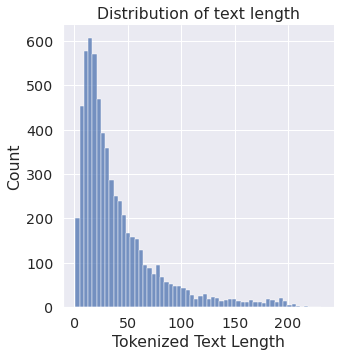

mean length: 40.47551566682412, median length 27.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt 

train['tokens_len'] = train.tokenized_text.apply(lambda x: len(x))
trial['tokens_len'] = trial.tokenized_text.apply(lambda x: len(x))

sns.set(palette='deep', color_codes=True, font_scale=1.3)
sns.displot(train.tokens_len)
plt.xlabel('Tokenized Text Length')
plt.title('Distribution of text length')
plt.show()

mean_length = np.mean(train.tokens_len)
median_length = np.median(train.tokens_len)
print('mean length: {}, median length {}'.format(mean_length, median_length))

Another important thing to check is the similarities of the distribution between the train and the trial sets. After plotting them below, we do not observe any differences that would make us rethink the strategy of splitting.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


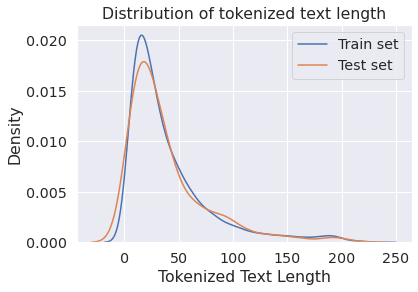

In [ ]:
sns.distplot(train.tokens_len, hist=False, label='Train set')
sns.distplot(trial.tokens_len, hist=False, label='Test set')
plt.xlabel('Tokenized Text Length')
plt.title('Distribution of tokenized text length')
plt.legend()
plt.show()

We will then plot the length of the toxic spans as a % of the text length, in order to get an idea of how lengthy the spans are. We observe that the toxic spans usually occupy <10% of the length of the text on both sets, trial and test 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


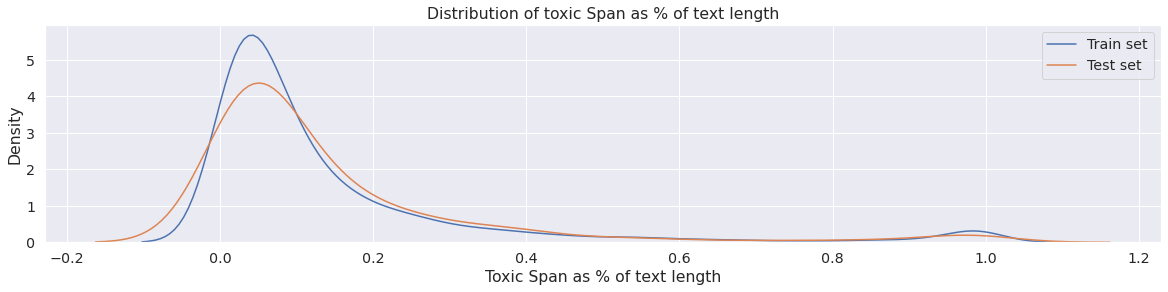

In [ ]:
fig, axs = plt.subplots(figsize=(20,4))
relative_length_spans_train = train.spans.str.len() / train.text.str.len()
relative_length_spans_trial = trial.spans.str.len() / trial.text.str.len()
sns.distplot(relative_length_spans_train, hist=False, label='Train set')
sns.distplot(relative_length_spans_trial, hist=False, label='Test set')
plt.xlabel('Toxic Span as % of text length')
plt.title('Distribution of toxic Span as % of text length')
plt.legend()
plt.show()

Another question that would be interesting to answer is where toxic spans usually appear in a sentence. How are they spread inside of a sentence? In effect, we are interested in the position of the toxic spans. In order to extract such info and since the length of each sentence may differ, we will need to normalize the position of each toxic span and relate it with the length of the sentence that it refers to. This can be achieved by dividing with the length of the sentence which will result in the percentile position of the span.

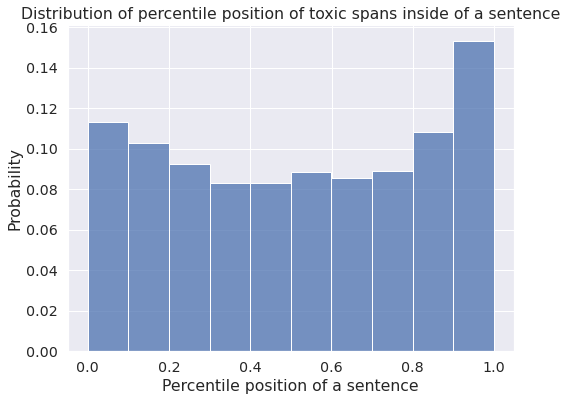

In [ ]:
# we will first need to normalize the position of the spans, that is to divide them by the length of each sentence
# thus we retrieve the % point of a sentence where a toxic span exists
normalized_spans = train.apply(lambda x: np.array(x.spans) / len(x.text), axis=1)
#then we concatenate all the spans to a single array
concatenated = np.concatenate(normalized_spans)
fig, axs = plt.subplots(figsize=(8,6))
sns.histplot(concatenated, stat='probability', bins=10)
plt.title('Distribution of percentile position of toxic spans inside of a sentence')
plt.xlabel('Percentile position of a sentence')
plt.show()

The first bar of the histogram above informs us that in the first 10% of the length of a sentence there is a probability of almost 12% to come across a toxic expression. Towards the end of the sentence and after its 90th percentile, there is a 15% probability of a toxic expression.

We observe almost a uniform distribution. There is a slight trend which shows that toxic expressions appear either during the start or during the end of a sentence, but not so intensely towards the middle.

The bins of the above plot can serve our purpose in multiple ways. If we use RNNs, we get an idea of how much info we will lose if we choose a small max length of a sentence. Another functionality that the above bins can offer, is that they can serve as apriori probabilities during the classification of a word as toxic/non toxic in a bayesian classification system.

Since we noticed some incosistencies regarding the way the toxic spans were created, we should have a look at the distribution of number of words that consist a toxic span. Some annotators might have cherry-picked specific words, while others might have included whole phrases or sentences. For this reason, we will tokenize the toxic words for spans with more than one word


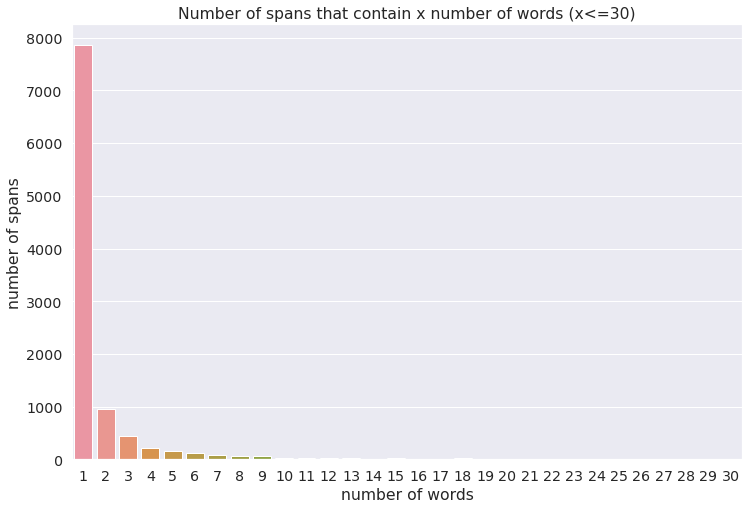

In [ ]:
from nltk.tokenize import TreebankWordTokenizer as wst
def tokenize_toxic_spans(toxic_phrases):
    #initialize a tokienizer
    t = wst()
    span_word_count = []
    #loop the toxic phrases and tokenize them
    for phrase in toxic_phrases:
        #count how many words are contained in a span
        words_contained_in_span = len(list(t.tokenize(phrase)))
        span_word_count.append(words_contained_in_span)
    return np.array(span_word_count)

words_contained_in_span = train.toxic_words.apply(tokenize_toxic_spans)
#concatenate in one dimension
words_contained_in_span = np.concatenate(words_contained_in_span)
#create bins and calculate the numbers of spans that contain x number of words
hist = np.histogram(words_contained_in_span,np.arange(1,101))[0]
hist = pd.DataFrame({'number of words': np.arange(1,100), 'number of spans':hist})
fig, axs = plt.subplots(figsize=(12,8))
sns.barplot(x=hist['number of words'][:30], y=hist['number of spans'][:30])
plt.title('Number of spans that contain x number of words (x<=30)')
plt.show()

From the plot above we can see tha the majority of toxic spans contain single words rather than phrases. This might prove to be convenient when using simpler algorithms that make predictions at the word level.



As a next step, we can load the glove embeddings, since we might use them in our analysis.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-01-18 18:29:26--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-01-18 18:29:26--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-01-18 18:29:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


We will load the embeddings with the 200 dimensions

In [ ]:
embeddings = pd.read_table("glove.6B.200d.txt", sep=" ", index_col=0, header=None, quoting=csv.QUOTE_NONE)
embeddings.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
the,-0.071549,0.093459,0.023738,-0.090339,0.056123,0.32547,-0.39796,-0.092139,0.061181,-0.189500,0.130610,0.14349,0.011479,0.38158,0.540300,-0.14088,0.243150,0.230360,-0.553390,0.048154,0.456620,3.2338,0.020199,0.049019,-0.014132,0.076017,-0.115270,0.200600,-0.077657,0.24328,0.163680,-0.341180,-0.066070,0.101520,0.038232,-0.17668,-0.88153,-0.33895,-0.035481,-0.550950,...,-0.042910,-0.067897,-0.29332,0.109780,-0.045365,0.232220,-0.311340,-0.289830,-0.666870,0.53097,0.194610,0.366700,0.26185,-0.65187,0.102660,0.113630,-0.129530,-0.682460,-0.187510,0.147600,1.0765,-0.22908,-0.009343,-0.206510,-0.352250,-0.26720,-0.003431,0.25906,0.217590,0.661580,0.121800,0.19957,-0.20303,0.344740,-0.243280,0.131390,-0.008877,0.336170,0.030591,0.255770
",",0.176510,0.292080,-0.002077,-0.375230,0.004914,0.23979,-0.28893,-0.014643,-0.109930,0.155920,0.206270,0.47675,0.099907,-0.14058,0.211140,0.12126,-0.318310,-0.089433,-0.090553,-0.319620,0.213190,2.4844,-0.077521,-0.084279,0.201860,0.260840,-0.404110,-0.191270,0.247150,0.22394,-0.063437,0.203790,-0.184630,-0.088413,0.024169,-0.28769,-0.61246,-0.12683,-0.088273,0.183310,...,0.026823,-0.045444,-0.22642,-0.199770,-0.121380,0.169410,0.061998,0.426310,-0.088383,0.45756,0.077774,0.061342,0.45710,-0.17787,-0.145970,0.326540,0.002443,-0.118860,0.100810,-0.020011,1.0366,-0.39814,-0.681800,0.236850,-0.203960,-0.17668,-0.313850,0.14834,-0.052187,0.061300,-0.325820,0.19153,-0.15469,-0.146790,0.046971,0.032325,-0.220060,-0.207740,-0.231890,-0.108140
.,0.122890,0.580370,-0.069635,-0.502880,0.105030,0.39945,-0.38635,-0.084279,0.122190,0.080312,0.323370,0.47579,-0.038375,-0.00709,0.415240,0.32121,-0.211850,0.361440,-0.055623,-0.030512,0.428540,2.8547,-0.146230,-0.175570,0.311970,-0.131180,0.033298,0.130930,0.089889,-0.12417,0.002340,-0.068954,-0.107540,-0.115510,-0.310520,-0.12097,-0.46691,-0.08360,-0.037664,-0.071779,...,0.075441,0.082116,-0.46008,0.012393,-0.025310,0.141770,-0.092192,0.345050,-0.521360,0.57304,0.011973,0.033196,0.29672,-0.27899,0.199790,0.256660,0.082079,-0.078436,0.093719,0.242020,1.3495,-0.30434,-0.309360,0.420470,-0.079068,-0.14819,-0.089404,0.06680,0.224050,0.272260,-0.035236,0.17688,-0.05360,0.007003,-0.033006,-0.080021,-0.244510,-0.039174,-0.162360,-0.096652
of,0.052924,0.254270,0.313530,-0.356130,0.029629,0.51034,-0.10716,0.151950,0.057698,0.061490,0.061160,0.39911,-0.000290,0.31978,0.432570,-0.14708,0.054842,0.270790,-0.140510,-0.301010,0.163130,3.0013,0.222310,-0.142790,0.083705,0.089866,-0.527060,-0.089661,0.273110,0.31413,-0.040810,0.060557,-0.042656,0.241780,-0.291870,0.22575,-0.62980,-0.14641,-0.224290,-0.056621,...,0.405320,-0.027960,-0.13398,-0.110860,0.059506,0.240520,-0.597390,-0.002407,-0.185930,1.04200,-0.129690,0.208130,0.33305,-0.12780,0.085662,-0.076422,0.314070,-0.237840,-0.054838,0.011369,0.8450,-0.34165,0.093983,0.082445,-0.277770,-0.44226,-0.063078,0.37274,0.054468,0.241970,-0.040886,0.38940,-0.10509,0.233720,0.096027,-0.303240,0.244880,-0.086254,-0.419170,0.464960
to,0.573460,0.541700,-0.234770,-0.362400,0.403700,0.11386,-0.44933,-0.309910,-0.005341,0.584260,-0.025956,0.49393,-0.037209,-0.28428,0.097696,-0.48907,0.026027,0.376490,0.057788,-0.468070,0.081288,3.2825,-0.636900,0.379560,0.003817,0.093607,-0.128550,0.173800,0.105220,0.28648,0.210890,-0.470760,0.027733,-0.198030,0.076328,-0.84629,-0.79708,-0.38743,-0.030422,-0.268490,...,-0.124130,-0.344310,-0.23296,-0.211870,0.085387,0.070063,-0.198030,-0.026023,-0.390370,0.80002,0.405770,-0.079863,0.35263,-0.34043,0.396760,0.228620,-0.350280,-0.473440,0.597420,-0.116570,1.0552,-0.41570,-0.080552,-0.056571,-0.166220,0.19274,-0.095175,-0.20781,0.156200,0.050231,-0.279150

We will create a dictionary with the words of our train test, get the appropriate vectors from the embeddings and visualize them. First we need to reduce our dataset in the 2D space. For that we will use PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)
reduced = pd.DataFrame(reduced, index = embeddings.index, columns=['pca_1','pca_2'])

Next, we will load the gensim model, which will assist us in finding similar words.

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# process the file so that it can be parsed as a word2vec model
glove_fn, glove_w2v_fn = 'glove.6B.100d.txt', 'glove.6B.200d.txt.word2vec' 
glove2word2vec(glove_fn, glove_w2v_fn)

# load the model 
glove_model = KeyedVectors.load_word2vec_format(glove_w2v_fn, binary=False)

Finally, we can proceed in plotting similar words, according to a given initial word.

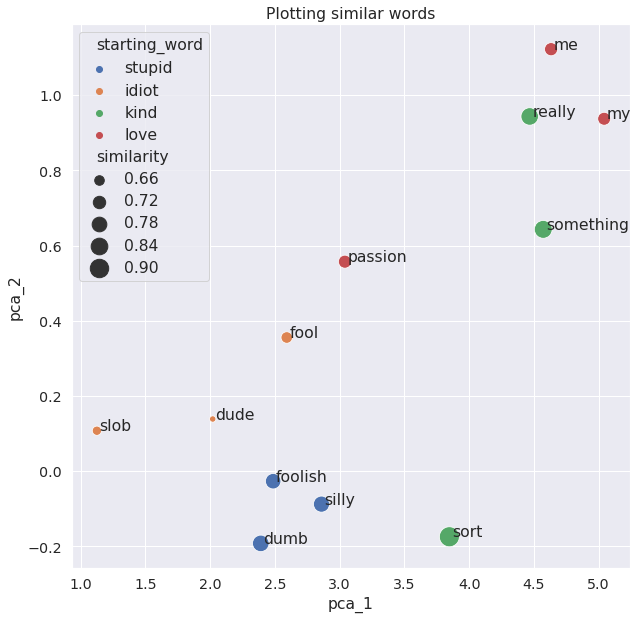

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def get_similar_words(words, topn=5):
    #return the most similar words, as well as the two principal components for each word
    res = []
    for word in words:
        # get the most similar words
        similar = glove_model.most_similar(word,  topn=topn)
        #append the word to a list, together with the word that triggered the most similar search
        # as well as the principal components for each similar word
        res += [(x[0], x[1], word, reduced.loc[x[0],'pca_1'], reduced.loc[x[0],'pca_2']) for x in similar]
    res_df = pd.DataFrame(res, columns = ['similar_word', 'similarity','starting_word', 'pca_1', 'pca_2'])
    return res_df

fig , axs = plt.subplots(figsize=(10,10))
random_words = get_similar_words(['stupid','idiot','kind','love'], 3)
sns.scatterplot(x='pca_1', y='pca_2', hue='starting_word', data=random_words, sizes=(40, 400), size='similarity')
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

label_point(random_words.pca_1, random_words.pca_2, random_words.similar_word, plt.gca()) 
plt.title('Plotting similar words')
plt.show()

# 4. Modeling

For modeling purposes, we will split the train dataset further into train and validation. We will use the train set to train our models, whereas the validation set will be used for optimizing any hyperparamters. Finally, the original trial set will be used for assessing the generalization capabilities of the model.

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(train, test_size=0.2, random_state=123)

## 4.1 ML Approach

The idea here is to build a classifier that will classify a text as toxic or non toxic. Then, by iteratively removing words from the text, we can see how the probit changes. When the probit of the classifier reduces below a specific threshold (the text became less toxic), the word shoud be flagged as toxic.

Since we want to train a classifier that classifies toxic texts as a whole we will need to enrich our dataset. We will introduce some texts which are non toxic. This will add discriminatory power to our classifier, since we observed common words in the toxic spans which are definetely non toxic on their own. By introducing some non toxic texts, the classifier will be able to discriminate better some common words. For this reason we introduced the dataset below. 

In [ ]:
tweets = pd.read_csv('https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv', index_col=0)

import re
def clean_text(text):
    #match http, s is optional, :// one slash is optional and everything that is not a whitespace
    hyperlinks = re.compile(r'https?://?[\S]*')
    text = re.sub(hyperlinks,'',text)
    
    #match RT and remove, because of retweets
    retweets = re.compile(r'RT')
    text = re.sub(retweets,'',text)

    #finding @ and match everything that is in [a-zA-Z0-9_]. this will include mentions without a separating space
    mentions = re.compile(r'@\w*')
    text = re.sub(mentions,'',text)
    
    #finding # and match everything that is in [a-zA-Z0-9_]. this will include hashtags without a separating space
    hashtags = re.compile(r'#\w*')
    text = re.sub(hashtags,'',text)
    
    newline = re.compile(r'\n')
    text = re.sub(newline,'',text)
    
    digits = re.compile('\d')
    text = re.sub(digits, '', text)
    
    #since we have removed eveyrthing else, anything that is not an alphanumeric will be removed and replaced with a space
    punctuation = re.compile(r'[\W]')
    text = re.sub(punctuation,' ',text)
    return text

#clean the tweets from unecesarry expressions
tweets['text'] = tweets.tweet.apply(clean_text)

#select the class==2, according to the documentation it is the non toxic class
non_toxic_tweets = tweets[tweets['class']==2].copy()
#since the tweets are non toxic we will populate with an empty span
non_toxic_tweets['spans'] = np.nan
#add the label of 0 since our tweets are non toxic
non_toxic_tweets['label'] = 0
#select the appropriate columns so that we have the same schema with the original dataframe
non_toxic_tweets = non_toxic_tweets[['text','spans','label']]

Having cleaned our additional dataset, we will concatenate it with the toxic texts.

In [ ]:
#create a copy of the original sets that we will use in our ML approach
ml_train = train[['text','spans']].copy()
ml_validation = validation[['text','spans']].copy()
ml_trial = trial[['text','spans']].copy()

#setting them a label of 1 as they are toxic
ml_train['label'] = 1
ml_validation['label'] = 1
ml_trial['label'] = 1

#we perform the similar split to the non toxic tweets
non_toxic_tweets_train, non_toxic_tweets_validation = train_test_split(non_toxic_tweets, random_state=123, test_size=0.2)
non_toxic_tweets_validation, non_toxic_tweets_trial = train_test_split(non_toxic_tweets_validation, random_state=123, test_size=0.5)

#we will concat the non toxic tweets to the toxic comments
ml_train = pd.concat([ml_train, non_toxic_tweets_train])
ml_validation = pd.concat([ml_validation, non_toxic_tweets_validation])
ml_trial = pd.concat([ml_trial, non_toxic_tweets_trial])

Instead of using Bag of Words, which could be limiting especially when unknown words appear in the text, we will use `Doc2Vec`. `Doc2vec` creates an embedding for the whole document, instead of each word of the document. Thus we could have a fixed number of features for each document, even after removing the words iteratively in order to assess their toxicity.

In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#Custom function for tagging the documents, necessary for doc2vec
def tag_documents(texts):
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(texts)]
    return documents

#tokenize the text and pass them to the tag_documents for all our sets.
#first we get all the spans
ml_train['all_spans'] = ml_train.text.apply(get_all_spans)
#from the spans we tokenize the text
ml_train['tokenized_text'] = ml_train.apply(lambda x: get_tokens(x.all_spans, x.text), axis=1)
#we tag the document, necessary for doc2vec
ml_train['tagged_document'] = tag_documents(ml_train.tokenized_text)

ml_validation['all_spans'] = ml_validation.text.apply(get_all_spans)
ml_validation['tokenized_text'] = ml_validation.apply(lambda x: get_tokens(x.all_spans, x.text), axis=1)
ml_validation['tagged_document'] = tag_documents(ml_validation.tokenized_text)

ml_trial['all_spans'] = ml_trial.text.apply(get_all_spans)
ml_trial['tokenized_text'] = ml_trial.apply(lambda x: get_tokens(x.all_spans, x.text), axis=1)
ml_trial['tagged_document'] = tag_documents(ml_trial.tokenized_text)

Since our dataset is in the right format, we can start training the `Doc2Vec` model. We initialized the model with a vector size of 20.

In [ ]:
#initialize the model
doc2vec = Doc2Vec(vector_size=20, epochs=50, seed=234)
#build the vocabulary, this is the same as the word to index notion
doc2vec.build_vocab(ml_train['tagged_document'])
#start training
doc2vec.train(ml_train['tagged_document'], total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

By accessing `doc2vec.docvecs.vectors_docs` we can see 20 features for each sentence in our train set.

In [ ]:
doc2vec.docvecs.vectors_docs.shape

(9681, 20)

We can also infer a vector using `doc2vec.infer_vector`

In [ ]:
doc2vec.infer_vector(['this', 'is', 'a', 'new','doc'])

array([ 0.23162256, -0.5380254 , -0.598471  ,  0.09237313,  0.07002359,
        0.06860597, -0.6642777 , -0.35684624, -0.4145721 , -0.1681378 ,
       -0.0479945 , -0.01755205,  0.02659309,  0.26117596, -0.5315298 ,
        0.53265446,  0.09237383,  0.12521072,  0.15452582, -0.03637572],
      dtype=float32)

Now we can start training our classifier. We can start with a Ranom Forest Classifier.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

grid = {
    'n_estimators' : [100,125,150,175,200]
    ,
    'max_depth' : [10,30,50,70,100,120]

}
rfc = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rfc, param_grid = grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(doc2vec.docvecs.vectors_docs, ml_train.label)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  3.4min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

These are our best parameters.

In [ ]:
print (grid_search.best_params_)

{'max_depth': 30, 'n_estimators': 150}


We can now fit a model using them.

In [ ]:
rfc = RandomForestClassifier(**grid_search.best_params_)
rfc.fit(doc2vec.docvecs.vectors_docs, ml_train.label)

#get the inferred vectors from the doc2vec model
validation_vectors = ml_validation.apply(lambda x: np.array(doc2vec.infer_vector(x.tokenized_text)), axis=1)
validation_vectors = np.vstack(validation_vectors)
#predict if the whole text is toxic or not
predictions = rfc.predict(validation_vectors)
print(classification_report(ml_validation[['label']],predictions))

              precision    recall  f1-score   support

           0       0.93      0.67      0.78       416
           1       0.92      0.99      0.95      1588

    accuracy                           0.92      2004
   macro avg       0.92      0.83      0.86      2004
weighted avg       0.92      0.92      0.92      2004



We will also train a linear classifier using the all familiar least squares. It is not a "best practice" approach but since the ouput of the classifier is not restricted to `[0,1]` we might be able to discriminate toxic words better.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

lr = LinearRegression()
lr.fit(doc2vec.docvecs.vectors_docs, ml_train.label)

#get the inferred vectors from the doc2vec model
validation_vectors = ml_validation.apply(lambda x: np.array(doc2vec.infer_vector(x.tokenized_text)), axis=1)
validation_vectors = np.vstack(validation_vectors)
#predict and binarize
predictions = lr.predict(validation_vectors)
predictions = (predictions > 0).astype(int)

print('f1 validation score:', f1_score(ml_validation[['label']], predictions))

f1 validation score: 0.9024529378208784


Additionally we will train a Lasso classifier in order to introduce some sparsity

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV()
lasso.fit(doc2vec.docvecs.vectors_docs, ml_train.label)

#get the inferred vectors from the doc2vec model
validation_vectors = ml_validation.apply(lambda x: np.array(doc2vec.infer_vector(x.tokenized_text)), axis=1)
validation_vectors = np.vstack(validation_vectors)

predictions = lasso.predict(validation_vectors)
predictions = (predictions > 0).astype(int)
print('f1 validation score:', f1_score(ml_validation[['label']], predictions))

f1 validation score: 0.9045714285714286


The next step is to create a class, that will handle the following tasks:

* Mask a word a time and predict the new toxicity of the text
* Tune a toxicity threshold under which a word is considered as toxic
* Predict toxic words for unseen data

In [ ]:
from sklearn.metrics import f1_score
from toxic_spans.evaluation.semeval2021 import f1
pd.options.mode.chained_assignment = None  # default='warn'
from tqdm import tqdm
tqdm.pandas(position=0, leave=True)

class InputErasure:

    def __init__(self, doc2vec_trained_model, validation_data, toxic_label, non_toxic_label):
        self.doc2vec = doc2vec_trained_model
        self.threshold = -0.2
        self.validation_data = validation_data
        self.toxic_label = toxic_label
        self.non_toxic_label = non_toxic_label
  
    def input_erasure_classifier(self, text, classifier):
        '''
        mask a word of the text and predict how much the toxicity score changes

        Parameters:
        text (str): tokenized text
        classifier (obj): a trained classifier with the perdict_proba function
            implemented
        
        Returns:
        list with word toxicity scores
        '''
        #infer the doc2vec vector if the original text
        original_doc_vector = [self.doc2vec.infer_vector(text,epochs=100)]
        #predict the toxicity of the initial text
        initial_score = classifier.predict_proba(original_doc_vector)[0,1]
        texts = []
        doc_vectors = []
        #mask each word of the text
        for word_index in range(len(text)):
            words_copy = [w for w in text]
            words_copy[word_index] = "[MASK]"
            #infer the the vectors of the whole document
            doc_vectors.append(self.doc2vec.infer_vector(words_copy,epochs=100))
            texts.append(words_copy)
        doc_vectors  = np.array(doc_vectors)
        # score all ablated texts
        scores = classifier.predict_proba(doc_vectors)[:,1]
        scores_pd = pd.DataFrame({"word":text, "xscore":scores})
        # measure the change in the score; decrease means guilty 
        scores_pd.xscore = scores_pd.xscore.apply(lambda score: (score-initial_score)/initial_score)
        return list(scores_pd.xscore)

    def input_erasure_regressor(self, text, regressor):
        #see input_erasure_classifier
        original_doc_vector = [self.doc2vec.infer_vector(text,epochs=100)]
        initial_score = regressor.predict(original_doc_vector)[0]
        texts = []
        doc_vectors = []
        for word_index in range(len(text)):
            words_copy = [w for w in text]
            words_copy[word_index] = "[MASK]"
            doc_vectors.append(self.doc2vec.infer_vector(words_copy,epochs=100))
            texts.append(words_copy)
        doc_vectors  = np.array(doc_vectors)
        scores = regressor.predict(doc_vectors)
        scores_pd = pd.DataFrame({"word":text, "xscore":scores})
        scores_pd.xscore = scores_pd.xscore.apply(lambda score: (score-initial_score)/initial_score)
        return list(scores_pd.xscore)
  
    def get_ground_truth_label_(self, all_spans, toxic_spans, toxic_label, non_toxic_label):
        '''
        iterate through all its spans and if they belong 
        to a toxic span assign toxic_label or non toxic_label

        Parameters:
        all_spans (list): list with all the spans of the text
        toxic_spans (list): list with toxic spans (not toxic span entities)
        toxic_label (int/array): the value of the label of a toxic word
        non_toxic_label (int/array): the value of the label of a nont toxic word 
        '''
        #if the beginng of a span or the end of a span belongs to a toxic span, assign the toxic label
        ground_truth = [toxic_label if span[0] in toxic_spans or span[1] in toxic_spans else non_toxic_label for span in all_spans]
        return ground_truth

    def tune_threshold(self, model, model_type):
        '''
        calculate the toxicity score of each word and tune the threshold

        Parameters:
        model (obj): any trained model with a method predict implemented
        model_type (str): valid values "regressor" or "classifier" 
        Returns:
        None
        '''

        #first we need to get the toxicity scores of each word
        print('scoring words...')
        #if we have a regressors, create a new column on the validation data set
        #with all the word scores, calling input_erasure_regressor on the tokenized texts
        if model_type == 'regressor':
            self.validation_data['word_scores'] = self.validation_data.progress_apply(
                lambda x: self.input_erasure_regressor(x.tokenized_text,model),axis=1)
        #similar procedure as above but we are calling input_erasure_classifier
        elif model_type == 'classifier':
            self.validation_data['word_scores'] = self.validation_data.progress_apply(
                lambda x: self.input_erasure_classifier(x.tokenized_text,model),axis=1)
    
        print('extracting ground truth labels...')
        #next we need to retrieve the ground  truth labels for each word of our 
        #validation data set, calling the helper function get_ground_truth_label_
        self.validation_data['ground_truth_label'] = self.validation_data.apply(
            lambda x: self.get_ground_truth_label_(x.all_spans, x.spans, self.toxic_label, self.non_toxic_label),axis=1)
    
        #next we will tune the threshold
        print('tuning the threshold...')
        word_scores = self.validation_data.word_scores
        labels = self.validation_data.ground_truth_label
        #calculate the decisions based on the threshold defined in the constructor
        decisions = [[1 if word < self.threshold else 0 for word in text] for text in word_scores]
        #calculate the initial score, being the optimal score so far
        #we use f1_score from https://github.com/ipavlopoulos/toxic_spans/blob/master/evaluation/semeval2021.py
        opt_score = np.mean([f1_score(decision, ground_truth_label, zero_division=1) for decision, ground_truth_label in list(zip(decisions, labels))])
        #start iterating for different values of thresholds
        for thr in np.linspace(0,-1,100):
            #calclate the updated decisions as well as the new score
            decisions = [[1 if word < thr else 0 for word in text] for text in word_scores]
            score = np.mean([f1_score(decision, ground_truth_label,zero_division=1) for decision, ground_truth_label in list(zip(decisions, labels))])
            #if the score is better, update the attribute self.threshold as well as the opt score
            if score > opt_score:
                self.threshold = thr
                opt_score = score
    
    def predict_spans(self, data, model, model_type):
        '''
        predict the toxic spans of a corpus

        Parameters:
        data: a dataset containing a tokenized text column
        model: a trained model with the predict method implemented
        model_type: valid values "regressor" or "classifier" 
        '''
        print('scoring words...')
        #call input_erasure_regressor or input_erasure_classifier based on model_type
        #in order to retrieve the word scores
        if model_type == 'regressor':
            data['word_scores'] = data.progress_apply(
                lambda x: self.input_erasure_regressor(x.tokenized_text,model),axis=1)
        elif model_type == 'classifier':
            data['word_scores'] = data.progress_apply(
                lambda x: self.input_erasure_classifier(x.tokenized_text,model),axis=1)
    
        #then we extract the toxic spans
        print('extracting spans...')
        predicted_spans = []
        #loop all the rows of our dataframe
        for _, row in data.iterrows():
            spans = []
            #for every doc, loop through the word scores
            for index, word_score in enumerate(row.word_scores):
            #if the score is below the threshold attribute, tuned in tune_threshold
            # get the span
                if word_score <= self.threshold:
                    span = row.all_spans[index]
                    #make the span continuous (1,4) -> [1,2,3,4]
                    for char in range(span[0], span[1]):
                        spans.append(char)
            predicted_spans.append(spans)
        print('done')
        return predicted_spans

    def evaluate(self, gold, predicted):
        '''
        Evaluate the fit using https://github.com/ipavlopoulos/toxic_spans/blob/master/evaluation/semeval2021.py

        Parameters:
        gold (list): list of continuous spans holding the ground truth 
        predicted (list): list of continuous spans holding the predictions
        '''
        df = pd.DataFrame({'gold' : gold, 'predicted' : predicted})
        df["f1_scores"] = df.apply(lambda row: f1(row.predicted, row.gold), axis=1)
        return df


After implementing a class for the input_erasure, we can test the fit of our models:

* The Random Forest Classifier
* The Linear Regression
* The Lasso Regression

Let's start with the Random Forest Classifier

In [ ]:
#initialize a model with our trained doc2vec model, passing our validation data only where the doc is toxic
ie = InputErasure(doc2vec,ml_validation[ml_validation.label==1], toxic_label = 1, non_toxic_label = 0)
#call tune_threshold which will find the optimal threshold based on the validation data
ie.tune_threshold(rfc, 'classifier')
#predict the spans of our unseen set
predictions = ie.predict_spans(ml_trial[ml_trial.label==1], rfc, 'classifier')
#final evaluation of the model
rfc_results = ie.evaluate(ml_trial[ml_trial.label==1].spans,predictions)
rfc_results.mean()

  0%|          | 2/1588 [00:00<02:22, 11.10it/s]

scoring words...


100%|██████████| 1588/1588 [13:15<00:00,  2.00it/s]


extracting ground truth labels...
tuning the threshold...


  0%|          | 2/690 [00:00<00:36, 18.67it/s]

scoring words...


100%|██████████| 690/690 [05:17<00:00,  2.17it/s]


extracting spans...
done


f1_scores    0.202697
dtype: float64

Moving on to our Linear Classifier

In [ ]:
ie_lr = InputErasure(doc2vec,ml_validation[ml_validation.label==1], toxic_label = 1, non_toxic_label = 0)
ie_lr.tune_threshold(lr, 'regressor')
predictions = ie_lr.predict_spans(ml_trial[ml_trial.label==1], lr, 'regressor')
lr_results = ie_lr.evaluate(ml_trial[ml_trial.label==1].spans,predictions)
lr_results.mean()

  0%|          | 2/1588 [00:00<01:51, 14.19it/s]

scoring words...


100%|██████████| 1588/1588 [12:39<00:00,  2.09it/s]


extracting ground truth labels...
tuning the threshold...


  0%|          | 0/690 [00:00<?, ?it/s]

scoring words...


100%|██████████| 690/690 [04:59<00:00,  2.30it/s]

extracting spans...
done


f1_scores    0.269715
dtype: float64

And finally the Lasso Linear Classifier

In [ ]:
ie_lasso = InputErasure(doc2vec,ml_validation[ml_validation.label==1], toxic_label = 1, non_toxic_label = 0)
ie_lasso.tune_threshold(lasso, 'regressor')
predictions = ie_lasso.predict_spans(ml_trial[ml_trial.label==1], lasso, 'regressor')
lasso_results = ie_lasso.evaluate(ml_trial[ml_trial.label==1].spans,predictions)
lasso_results.mean()

  0%|          | 2/1588 [00:00<01:57, 13.46it/s]

scoring words...


100%|██████████| 1588/1588 [12:40<00:00,  2.09it/s]


extracting ground truth labels...
tuning the threshold...


  0%|          | 0/690 [00:00<?, ?it/s]

scoring words...


100%|██████████| 690/690 [05:00<00:00,  2.29it/s]

extracting spans...
done


f1_scores    0.260084
dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

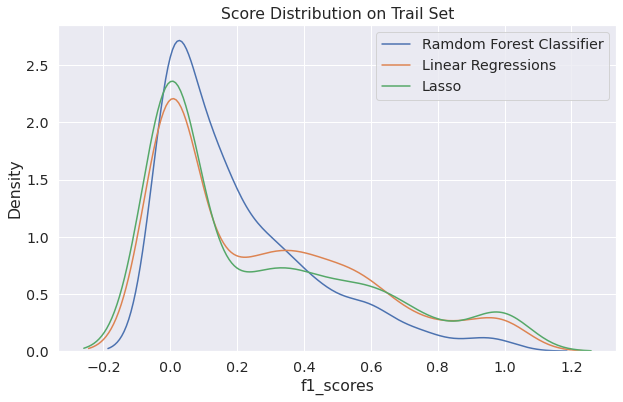

Input Erasure with Random Classifier: 0.20270
Input Erasure with Linear Classifier: 0.26972
Input Erasure with Lasso Linear Classifier: 0.26008


In [ ]:
fig, axs = plt.subplots(figsize=(10,6))
sns.distplot(rfc_results.f1_scores, hist=False, label='Ramdom Forest Classifier')
sns.distplot(lr_results.f1_scores, hist=False, label = 'Linear Regressions')
sns.distplot(lasso_results.f1_scores, hist=False, label = 'Lasso')
axs.title.set_text('Score Distribution on Trail Set')
plt.legend()
plt.show()

print('Input Erasure with Random Classifier:', '%.5f' % rfc_results.f1_scores.mean())
print('Input Erasure with Linear Classifier:', '%.5f' % lr_results.f1_scores.mean())
print('Input Erasure with Lasso Linear Classifier:', '%.5f' % lasso_results.f1_scores.mean())

One can observe that the Input Erasure with the Linear Approach was able to discriminate better toxic scores. The Lasso Linear Classifier did not overperform the unconstrained Linear Classifier though. The Input Erasure with the Random Forest Classifier performed poorly compared to the simpler linear approaches.

## 4.2 RNN Approach

As described in **1. Get The data** we have cloned a fork https://github.com/iliasKatsabalos/toxic_spans which contained some adjustments of the original repo, in order to enable the functionality of pretrained embeddings. The differences with the master of the original repo are highlighted [here](https://github.com/ipavlopoulos/toxic_spans/compare/master...iliasKatsabalos:pretrained_embeddings)

In [ ]:
#import all the necessary librarires
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
import seaborn as sns
from keras.models import Model, Input
from keras.layers import GRU, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras import callbacks
from keras.utils import plot_model

In [ ]:
#install lime
!pip install lime
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 276kB 5.1MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=ee904628705d66d574d6a3eda53c050873bd490086c9d874e49530c84743bed8
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
def ground_truth_label(all_spans, toxic_spans, toxic_label=[0,0,1], non_toxic_label=[0,1,0]):
    '''
    Returns the ground thruth label for each word
    
    Parameters:
        all_spans (list): list of tuples containing the spans of all the tokens
                            where the first element of the tuple is the beginning of the span
                            and the second element is the end of the token span
        toxic_spans (list): list of integers containing the toxic spans
        toxic_label (int/list): labels each token as toxic
        non_toxic_label (int/list): labels each token as non toxic
    
    Returns:
        np.array: ground truth labels for each token of a doc
    '''
    ground_truth = [toxic_label if span[0] in toxic_spans or span[1] in toxic_spans else non_toxic_label for span in all_spans]
    return np.array(ground_truth)

#The Xs for the current set up are tokenized texts
X_train = train.tokenized_text
#Getting the ground thruth label for our train set. 
#Since the architecture of the RNN has a Time Distributed Layer with 3 nodes
#we need to adjust, thus we use an array with 3 dimensions as a label
y_train = train.apply(lambda x: ground_truth_label(x.all_spans, x.spans), axis=1)

We will start by fitting an RNN without embeddings and a max length of 128 words

In [ ]:
from toxic_spans.baselines.models import RNNSL
rnn_no_emb_128 = RNNSL(max_epochs=15, maxlen=128)
rnn_no_emb_128.fit(train.tokenized_text, y_train)

In [ ]:
def predict_spans(data, model, threshold):
    '''
    based on a threshold, decide if a word is toxic or non toxic and
    retrive the continuous spans

    Parameters:
        data (pandas dataframe): a dataframe that contains a tokenized text
        model (obj): RNN trained model
        threshold (float): a number which is the cut off score for a toxic word
    Returns:
        predicted_spans (list): list of continous indices assigned as toxic
    '''
    data['word_scores'] = model.predict(data.tokenized_text)
    predicted_spans = []
    #iterate over the rows of the dataframe
    for _, row in data.iterrows():
        spans = []
        #iterate over the tokens of a text
        for index in range(min(len(row.tokenized_text), model.maxlen)):
            word_score = row.word_scores[index]
            #if the word score of the token is above the threshold, get the continuous span
            if word_score > threshold:
                span = row.all_spans[index]
                for char in range(span[0], span[1]):
                #append all indices of the characters
                    spans.append(char)
        predicted_spans.append(spans)
    return predicted_spans

from toxic_spans.evaluation.semeval2021 import f1

def tune_rnn_threshold(validation_data, model):
    '''
    For different value of thresholds, calculate the f1 score and keep the optimal threshold

    Parameters:
        validation_data (dataframe): dataframe with tokenized texts
        model (RNN): trained RNN model

    '''
    #get the initial predicted spans
    predicted_spans = predict_spans(validation_data, model, model.threshold)
    #calculate the initial f1 score
    result = pd.DataFrame({'gold':validation.spans, 'predicted':predicted_spans})
    result["f1_scores"] = result.apply(lambda row: f1(row.predicted, row.gold), axis=1)
    opt_score = result.f1_scores.mean()
    #loop through different thresholds
    for thr in tqdm(np.linspace(0.15,0.5,40), position=0, leave=True):
        #get the preducted spans
        predicted_spans = predict_spans(validation_data, model, thr)
        #calculate the updated score
        result = pd.DataFrame({'gold':validation.spans, 'predicted':predicted_spans})
        result["f1_scores"] = result.apply(lambda row: f1(row.predicted, row.gold), axis=1)
        score = result.f1_scores.mean()
        #if the new score is higher, proceed updating optmial score and model threshold
        if score > opt_score:
            opt_score = score
            model.threshold = thr

validation['ground_truth_label'] = validation.apply(lambda x: ground_truth_label(x.all_spans, x.spans, toxic_label=2, non_toxic_label=1), axis=1)

In [ ]:
tune_rnn_threshold(validation, rnn_no_emb_128)
rnn_no_emb_128_predicted_spans = predict_spans(trial, rnn_no_emb_128, rnn_no_emb_128.threshold)
result_rnn_no_emb_128 = pd.DataFrame({'gold':trial.spans, 'predicted':rnn_no_emb_128_predicted_spans})
result_rnn_no_emb_128["f1_scores"] = result_rnn_no_emb_128.apply(lambda row: f1(row.predicted, row.gold), axis=1)
print('f1 score:', result_rnn_no_emb_128.f1_scores.mean())

100%|██████████| 40/40 [03:12<00:00,  4.81s/it]


f1 score: 0.5728349574324381


No we will fit the same model using pretrained embeddings

In [ ]:
rnn_128 = RNNSL(max_epochs=15, embeddings=embeddings ,maxlen=128, patience=3)
rnn_128.fit(train.tokenized_text, y_train)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 200)          4971000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128, 400)          641600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 3)            1203      
Total params: 5,613,803
Trainable params: 5,613,803
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
179/179 [==============================] - 199s 1s/step - loss: 0.0618 - accuracy: 0.9261 - precisi

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.049943,0.948507,0.919761,0.926335,0.975660,0.041513,0.957731,0.936504,0.936702,0.980541
1,0.042704,0.957766,0.936698,0.936593,0.981624,0.040824,0.957915,0.936983,0.936745,0.981787
2,0.040140,0.959350,0.938929,0.939136,0.984393,0.039807,0.959950,0.939664,0.940221,0.982494
3,0.035069,0.961467,0.942146,0.942264,0.989552,0.041964,0.959215,0.938934,0.938695,0.980589
4,0.025169,0.970071,0.955188,0.955016,0.994868,0.047798,0.953788,0.930719,0.930640,0.977415
5,0.018882,0.976728,0.965010,0.965180,0.997034,0.052161,0.951485,0.927317,0.927121,0.975910


Then tune its threshold

In [ ]:
tune_rnn_threshold(validation, rnn_128)

100%|██████████| 40/40 [03:15<00:00,  4.88s/it]


Then calculate the f1 score

In [ ]:
rnn_128_predicted_spans = predict_spans(trial, rnn_128, rnn_128.threshold)
result_rnn_128 = pd.DataFrame({'gold':trial.spans, 'predicted':rnn_128_predicted_spans})
result_rnn_128["f1_scores"] = result_rnn_128.apply(lambda row: f1(row.predicted, row.gold), axis=1)
result_rnn_128.f1_scores.mean()

0.5803486052677287

Next we can try a model with naxlen = 80

In [ ]:
rnn_80 = RNNSL(max_epochs=15, embeddings=embeddings ,maxlen=80, patience=3)
rnn_80.fit(train.tokenized_text, y_train)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 200)           4971000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 80, 200)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 400)           641600    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 80, 3)             1203      
Total params: 5,613,803
Trainable params: 5,613,803
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
179/179 [==============================] - 124s 665ms/step - loss: 0.0890 - accuracy: 0.9387 - prec

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.072772,0.950330,0.922556,0.928973,0.975428,0.061687,0.956422,0.934593,0.934680,0.980088
1,0.062735,0.956439,0.934597,0.934727,0.981477,0.059318,0.958164,0.937287,0.937200,0.982062
2,0.057929,0.958270,0.937416,0.937393,0.985286,0.060993,0.958289,0.937270,0.937620,0.981650
3,0.048687,0.961419,0.942214,0.942031,0.990693,0.064945,0.956687,0.934888,0.935193,0.979227
4,0.033007,0.971937,0.957827,0.957990,0.995769,0.073868,0.953872,0.930848,0.930761,0.976052


Tune its threshold

In [ ]:
tune_rnn_threshold(validation, rnn_80)

100%|██████████| 40/40 [02:10<00:00,  3.27s/it]


Calculate its score

In [ ]:
rnn_80_predicted_spans = predict_spans(trial, rnn_80, rnn_80.threshold)
result_rnn_80 = pd.DataFrame({'gold':trial.spans, 'predicted':rnn_80_predicted_spans})
result_rnn_80["f1_scores"] = result_rnn_80.apply(lambda row: f1(row.predicted, row.gold), axis=1)
result_rnn_80.f1_scores.mean()

0.5301957689370314

We will also fit a model with a bigger max len, in order to cover longer texts.

In [ ]:
#tune_rnn_threshold(validation, rnn_256)
rnn_256_predicted_spans = predict_spans(trial, rnn_256, rnn_256.threshold)
result_rnn_256 = pd.DataFrame({'gold':trial.spans, 'predicted':rnn_256_predicted_spans})
result_rnn_256["f1_scores"] = result_rnn_256.apply(lambda row: f1(row.predicted, row.gold), axis=1)
result_rnn_256.f1_scores.mean()

100%|██████████| 40/40 [05:22<00:00,  8.06s/it]


0.6024498935114695

In [ ]:
rnn_256 = RNNSL(max_epochs=15, embeddings=embeddings ,maxlen=256, patience=3)
rnn_256.fit(train.tokenized_text, y_train)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 256, 200)          4971000   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256, 200)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256, 400)          641600    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 256, 3)            1203      
Total params: 5,613,803
Trainable params: 5,613,803
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
179/179 [==============================] - 371s 2s/step - loss: 0.0312 - accuracy: 0.9387 - precisi

,loss,accuracy,precision,recall,auc,val_loss,val_accuracy,val_precision,val_recall,val_auc
0,0.025630,0.951699,0.925000,0.930549,0.976484,0.021359,0.959076,0.938632,0.938594,0.981747
1,0.022528,0.957974,0.936930,0.936999,0.981020,0.021266,0.959675,0.939602,0.939410,0.982263
2,0.021217,0.959567,0.939340,0.939364,0.983672,0.020043,0.961035,0.941606,0.941491,0.983471
3,0.019749,0.960955,0.941360,0.941514,0.986910,0.020671,0.960015,0.939878,0.940185,0.982937
4,0.015309,0.966005,0.948928,0.949095,0.993026,0.023313,0.957743,0.936206,0.937084,0.979318
5,0.011027,0.974662,0.961975,0.962013,0.996264,0.025487,0.955010,0.932338,0.932719,0.977571


Tune its threshold

In [ ]:
tune_rnn_threshold(validation, rnn_256)

  0%|          | 0/40 [00:00<?, ?it/s]

0.5525495398168636


100%|██████████| 40/40 [06:03<00:00,  9.10s/it]


Then calculate the f1 score

In [ ]:
rnn_256_predicted_spans = predict_spans(trial, rnn_256, rnn_256.threshold)
result_rnn_256 = pd.DataFrame({'gold':trial.spans, 'predicted':rnn_256_predicted_spans})
result_rnn_256["f1_scores"] = result_rnn_256.apply(lambda row: f1(row.predicted, row.gold), axis=1)
result_rnn_256.f1_scores.mean()

0.6014107307948245

No we can compare the results of our RNN models

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

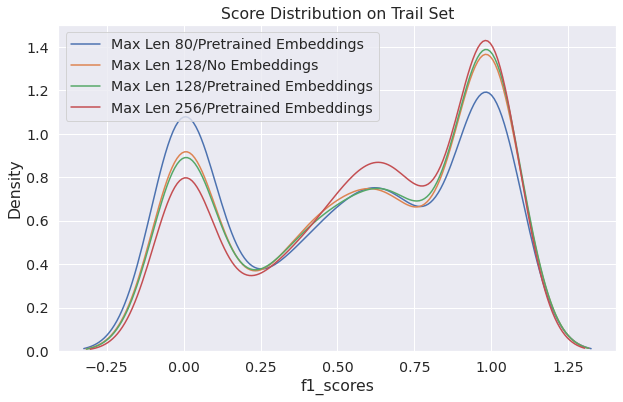

Max Len 80/Pretrained Embeddings: 0.53020
Max Len 128/No Embeddings: 0.57283
Max Len 128/Pretrained Embeddings: 0.58035
Max Len 256/Pretrained Embeddings: 0.60141


In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(figsize=(10,6))
sns.distplot(result_rnn_80.f1_scores, label='Max Len 80/Pretrained Embeddings', hist=False)
sns.distplot(result_rnn_no_emb_128.f1_scores, label='Max Len 128/No Embeddings', hist=False)
sns.distplot(result_rnn_128.f1_scores, label='Max Len 128/Pretrained Embeddings', hist=False)
sns.distplot(result_rnn_256.f1_scores, label='Max Len 256/Pretrained Embeddings', hist=False)
axs.title.set_text('Score Distribution on Trial Set')
plt.legend()
plt.show()

print('Max Len 80/Pretrained Embeddings:', '%.5f' % result_rnn_80.f1_scores.mean())
print('Max Len 128/No Embeddings:', '%.5f' % result_rnn_no_emb_128.f1_scores.mean())
print('Max Len 128/Pretrained Embeddings:', '%.5f' % result_rnn_128.f1_scores.mean())
print('Max Len 256/Pretrained Embeddings:', '%.5f' % result_rnn_256.f1_scores.mean())

From the four models that we ran we observed that the model with the highest generalization power is the one with `max len = 256` which uses pretrained embeddings. Comparing the models with `max len = 128` with and without embeddings, we can observe a small uplift when using embeddings.

## 4.3 Spacy
For spacy we will use the Command Line Interface as described [here](https://spacy.io/api/cli), since it allows us for further tuning our models. First we need to proceed to some more preprocessing, namely extracting span entities and attaching the label `TOXIC`.

In [ ]:
import spacy
from spacy.gold import docs_to_json
import srsly

First we will need to download the `en_core_web_lg` model since we will pretrain our embeddings based on it



In [ ]:
!python -m spacy download en_core_web_lg
#you might need to restart the colab runtime after installing this

In [ ]:
nlp = spacy.load('en_core_web_lg')

Since we will work with the CLI interface of Spacy, we will need to transform our data to a specific json format. The following 3 functions take care of the preprocessing.

In [ ]:
def spacy_json_format_pretraining(data, filename):
    '''
    transforms given texts to the desirable jsonl format, 
    applicable for pretraining embeddings.

    Parameters:
        data (pandas dataframe): a pandas dataframe with a column containing the texts
        filename (str): the name of the jsonl file provided as an output
    '''
    DATA = []
    for _, row in enumerate(data):
        DATA.append({'text':row})
    srsly.write_jsonl(filename + ".jsonl", DATA)

def spacy_json_format(data, filename):
    '''
    transforms a corpus to a json format usable for the train command of the CLI

    Parameters:
        data (pandas dataframe): a pandas dataframe with a column containing the texts
        filename (str): the name of the jsonl file provided as an output
    '''
    DATA = []
    for _, row in data.iterrows():
        doc = nlp(row.text)
        ents = spans_to_ents(doc, set(row.spans))
        DATA.append((doc.text, {'entities': ents}))
    
    docs = []
    for text, annot in DATA:
        doc = nlp(text)
        doc.ents = [doc.char_span(start_idx, end_idx, label=label) for start_idx, end_idx, label in annot["entities"]]
        docs.append(doc)

    srsly.write_json(filename + ".json", [docs_to_json(docs)])

def spans_to_ents(doc, toxic_spans):
    '''
    Converts continous spans to entity spans 
    and assigns the toxic label [1,2,3,7,8,9] -> [(1,3,TOXIC),(7,9,TOXIC)]
    '''
    started = False
    left, right, ents = 0, 0, []
    for token in doc:
        if token.pos_ == 'SPACE': continue
        # if the token is in the spans return just the starting-ending offsets
        if toxic_spans.intersection(set(range(token.idx, token.idx + len(token.text)))):
            if not started:        
                left, started = token.idx, True
            right = token.idx + len(token.text)
        # this is activated when "started" is True and we moved on a non-toxic word,
        # so, just return the saved left/right offsets.
        elif started:
            ents.append((left, right, 'TOXIC'))
            started = False
    if started: 
        ents.append((left, right, 'TOXIC'))
    return ents

In [ ]:
#transform the data to json files which we will use for training and validation
spacy_json_format(train,'ent_train_data')
spacy_json_format(validation, 'ent_validation_data')

In [ ]:
#transform the entire corpus for using it for pretraining our embeddings
all_docs = pd.concat([train.text,trial.text,validation.text])
spacy_json_format_pretraining(all_docs, 'ent_train_data_pre')

Now that we have our data in a specific format, we will start with pretraining our embeddings. In the command line below, we pass the texts of our corpus, the `en_core_web_lg` model as well as the folder of the output `pretrained_embeddings`. We will train our embeddings for 100 epochs, using a dropout of `0.2` and a random seed of `123`

In [ ]:
!spacy pretrain ent_train_data_pre.jsonl en_core_web_lg  pretrained_embeddings -i 50 -d 0.2 -s 123

ℹ Not using GPU
✔ Created output directory: pretrained_embeddings
✔ Saved settings to config.json
✔ Loaded input texts
✔ Loaded model 'en_core_web_lg'

============== Pre-training tok2vec layer - starting at epoch 0 ==============
  #      # Words   Total Loss     Loss    w/s
  0       131178   130282.266   130282   6115
  0       260243   255333.023   125050   7366
  0       374589   361831.742   106498   7312
  1       506449   479384.836   117553   7454
  1       635429   585181.961   105797   7638
  1       749178   671046.008    85864   7608
  2       877531   759876.602    88830   7439
  2      1010383   843163.039    83286   7801
  2      1123767   909655.445    66492   7482
  3      1252544   981397.477    71742   7426
  3      1386274   1052810.99    71413   7449
  3      1498356   1111002.08    58191   7057
  4      1626320   1175769.77    64767   7292
  4      1755366   1239992.89    64223   7424
  4      1872945   1298035.88    58042   7417
  5      2002865   1361458.34    

After pretraining our embeddings, we will start training our actual model. Through the command line below we pass the following parameters

* Dropout rate starting at 0.5
* Our training dataset with the toxic labels is `ent_train_data.json`
* Our validation dataset  is `ent_validation_data.json`
* We will train only a Named Entity Recognition model `ner`
* Early stopping has beed defined to 3
* We will run 80 iterations
* We will use the gpu
* We will start with pretrained vectors found in `pretrained_embeddings/model49.bin`

In [ ]:
! dropout_from=0.5 spacy train en toxic_1 ent_train_data.json ent_validation_data.json -p 'ner' -ne 3 -n 50 -g 0 -t2v pretrained_embeddings/model49.bin

✔ Created output directory: toxic_1
Training pipeline: ['ner']
⚠ Unable to activate GPU: 0
Using CPU only
Starting with blank model 'en'
Counting training words (limit=0)
Loaded pretrained tok2vec for: ['ner']

Itn  NER Loss   NER P   NER R   NER F   Token %  CPU WPS
---  ---------  ------  ------  ------  -------  -------
  1  22038.096  65.960  47.607  55.301  100.000    22469
  2  20839.497  65.546  50.025  56.743  100.000    23864
  3  19956.960  65.287  50.567  56.992  100.000    23570
  4  19833.125  65.703  50.469  57.087  100.000    24033
  5  18175.187  65.659  50.370  57.007  100.000    23767
  6  17778.588  65.424  50.222  56.824  100.000    23972
  7  17368.735  65.280  51.110  57.333  100.000    23350
  8  16748.347  65.059  51.258  57.340  100.000    23653
  9  16276.457  63.899  51.258  56.885  100.000    23169
 10  15751.470  63.525  51.209  56.706  100.000    23861
Early stopping, best iteration is: 6
Best score = 57.90767117963725; Final iteration score = 57.146530888

Having trained our model we can load it in order to perform predictions.

In [ ]:
cnlp = spacy.load('toxic_1/model-best')

Let's see how this model performs on unseen data.

In [ ]:
def get_char_spans(entities):
    '''
    For every span entity generate the continuous spans
    '''
    char_spans = []
    for ent in entities:
        for i in range (ent.start_char, ent.end_char):
          char_spans.append(i)
    return char_spans

#apply our trained model on all the texts on trial
trial['nlp_doc'] = trial.text.apply(cnlp)
#get the entities 
trial['entities'] = trial.nlp_doc.apply(lambda x: x.ents)
#generate the continuous toxic spans
trial['predicted_spans'] = trial.entities.apply(get_char_spans)

from toxic_spans.evaluation.semeval2021 import f1
spacy_results = pd.DataFrame({'gold':trial.spans, 'predicted':trial.predicted_spans})
spacy_results["f1_scores"] = spacy_results.apply(lambda row: f1(row.predicted, row.gold), axis=1)
print('spacy f1 score:', spacy_results.f1_scores.mean())

spacy f1 score: 0.6012088552230647



## 4.4 Spacy with Transformers

According to spacy `v.3`, there are some new models which include transformers with the name entity recognition pipeline added to them. We will proceed in a quick implementation of one of these models.
https://nightly.spacy.io/models/en#en_core_web_trf

First we need to install the update version of spacy.

In [ ]:
! pip install spacy-nightly --pre

Make sure that it has been successfully updated

In [ ]:
!spacy info

2021-01-18 17:07:00.507098: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

============================== Info about spaCy ==============================

spaCy version    3.0.0rc2                      
Location         /usr/local/lib/python3.6/dist-packages/spacy
Platform         Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
Python version   3.6.9                         
Pipelines                                      



Then we will download the `en_core_web_sm` for the version `3.0`

In [ ]:
! python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
from spacy.tokens import DocBin
from spacy.training import Example

def spacy_format(data, filename):
    
    '''
    transforms a corpus to a spacy format usable for the train command of the CLI

    Parameters:
        data (pandas dataframe): a pandas dataframe with a column containing the texts
        filename (str): the name of the jsonl file provided as an output
    '''
    DATA = []
    for _, row in data.iterrows():
        doc = nlp(row.text)
        ents = spans_to_ents(doc, set(row.spans))
        DATA.append((doc.text, {'entities': ents}))
    
   
    db = DocBin()

    for text, annotations in DATA:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        db.add(example.reference)
    
    db.to_disk(filename + ".spacy")

def spans_to_ents(doc, toxic_spans):
    '''
    Converts continous spans to entity spans 
    and assigns the toxic label [1,2,3,7,8,9] -> [(1,3,TOXIC),(7,9,TOXIC)]
    '''
    started = False
    left, right, ents = 0, 0, []
    for token in doc:
        if token.pos_ == 'SPACE': continue
        # if the token is in the spans return just the starting-ending offsets
        if toxic_spans.intersection(set(range(token.idx, token.idx + len(token.text)))):
            if not started:        
                left, started = token.idx, True
            right = token.idx + len(token.text)
        # this is activated when "started" is True and we moved on a non-toxic word,
        # so, just return the saved left/right offsets.
        elif started:
            ents.append((left, right, 'TOXIC'))
            started = False
    if started: 
        ents.append((left, right, 'TOXIC'))
    return ents

The following lines of code will help us to convert our training data to an input applicable for the spacy version `3.0`

In [ ]:
spacy_format(train,'ent_train_data')
spacy_format(validation,'ent_validation_data')

Since we will be usings transformers, we will need to install them first.

In [ ]:
!pip install spacy-nightly[transformers] --pre

Spacy `v3.0` has slightly changed the process of training. It is essential to include a configuration file which holds parameters relative to the process of training, like max epochs, patience etc. We have pushed such a file in our development branch of the toxic_spans repository. Then we will perform an overall debugging to see if our data and our configuration file are in the right format.

In [ ]:
!spacy debug data toxic_spans/baselines/spacy_config.cfg --paths.train ent_train_data.spacy --paths.dev ent_validation_data.spacy

2021-01-18 15:55:19.842144: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

============================ Data file validation ============================
✔ Corpus is loadable
Downloading: 100% 481/481 [00:00<00:00, 393kB/s]
Downloading: 100% 899k/899k [00:00<00:00, 1.81MB/s]
Downloading: 100% 456k/456k [00:00<00:00, 1.36MB/s]
Downloading: 100% 501M/501M [00:11<00:00, 45.3MB/s]
✔ Pipeline can be initialized with data

=============================== Training stats ===============================
Language: en
Training pipeline: transformer, ner
6351 training docs
1588 evaluation docs
✔ No overlap between training and evaluation data

============================== Vocab & Vectors ==============================
ℹ 274982 total word(s) in the data (274982 unique)
ℹ No word vectors present in the package

========================== Named Entity Recognition ==========================
ℹ 0 new label(s), 1 existing label(s)


Since we do not see any errors, we can start training.

In [ ]:
!spacy train toxic_spans/baselines/spacy_config.cfg --output toxic_trans --paths.train ent_train_data.spacy --paths.dev ent_validation_data.spacy -g 0

2021-01-18 17:28:20.538245: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
Set up nlp object from config
Pipeline: ['transformer', 'ner']
Created vocabulary
Finished initializing nlp object
Initialized pipeline components: ['transformer', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['transformer', 'ner']
ℹ Initial learn rate: 0.0
E    #       LOSS TRANS...  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  -------------  --------  ------  ------  ------  ------
  0       0       12854.04    635.00    0.86    0.57    1.68    0.01
  1     200      303585.78  44541.13   59.55   63.08   56.39    0.60
  2     400        5729.12  16251.71   57.69   72.29   48.00    0.58
  3     600        5126.91  14735.79   59.65   63.56   56.19    0.60
  4     800 

In [ ]:
import spacy
trans_nlp = spacy.load('toxic_trans/model-best')

In [ ]:
def get_char_spans(entities):
  char_spans = []
  for ent in entities:
    for i in range (ent.start_char, ent.end_char):
      char_spans.append(i)
  return char_spans

trial['nlp_doc'] = trial.text.apply(trans_nlp)
trial['entities'] = trial.nlp_doc.apply(lambda x: x.ents)
trial['predicted_spans'] = trial.entities.apply(get_char_spans)

from toxic_spans.evaluation.semeval2021 import f1
spacy_results_trans = pd.DataFrame({'gold':trial.spans, 'predicted':trial.predicted_spans})
spacy_results_trans["f1_scores"] = spacy_results_trans.apply(lambda row: f1(row.predicted, row.gold), axis=1)
print('spacy f1 score:', spacy_results_trans.f1_scores.mean())

spacy f1 score: 0.6452400504382623


# Overall Results

Now that we have tried several approaches, we can proceed with summarizing the results. We will visualize distribution of the f1 scores for the best models of each approach, namely:

* The Input Erasure with a linear least squares classifier
* The RNN with max len 256 with pretrained_embeddings
* The Spacy model using transformers

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

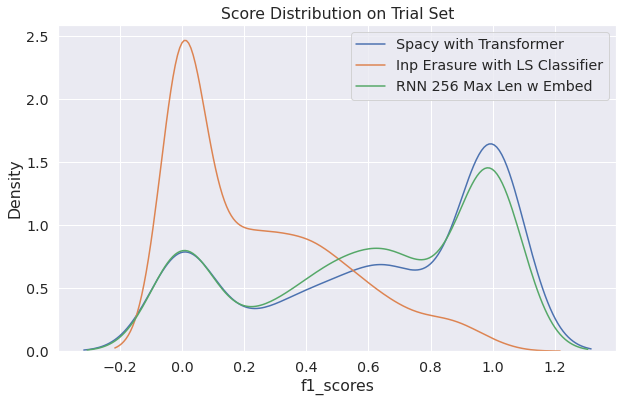

Avg f1 Inp Erasure with LS Classifier: 0.23933
Avg f1 RNN 256 Max Len w Embed: 0.60245
Avg f1 Spacy with Transformer 0.62872


In [ ]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(figsize=(10,6))
sns.distplot(spacy_results_trans.f1_scores, label='Spacy with Transformer', hist=False)
sns.distplot(lr_results.f1_scores, label='Inp Erasure with LS Classifier', hist=False)
sns.distplot(result_rnn_256.f1_scores, label='RNN 256 Max Len w Embed', hist=False)
axs.title.set_text('Score Distribution on Trial Set')
plt.legend()
plt.show()

print('Avg f1 Inp Erasure with LS Classifier:', '%.5f' % lr_results.f1_scores.mean())
print('Avg f1 RNN 256 Max Len w Embed:', '%.5f' % result_rnn_256.f1_scores.mean())
print('Avg f1 Spacy with Transformer', '%.5f' % spacy_results_trans.f1_scores.mean())

Spacy with Roberta Based transformers seems to produce the best result on the trial data. The RNN comes pretty close, although it did not manage to surpass the "plug&run" spacy results. Finally, the input erasure method performed really poorly compared to the most sophisticated approaches.

# Output File

In [ ]:
test = pd.read_csv('tsd_test.csv')

test['nlp_doc'] = test.text.apply(trans_nlp)
test['entities'] = test.nlp_doc.apply(lambda x: x.ents)
test['predicted_spans'] = test.entities.apply(get_char_spans)
final_predictions = test.predicted_spans

In [ ]:
# make sure that the ids match the ones of the scores
predictions = final_predictions
ids = test.index.to_list()

# write in a prediction file named "spans-pred.txt"
with open("spans-pred.txt", "w") as out:
  for uid, text_scores in zip(ids, predictions):
    out.write(f"{str(uid)}\t{str(text_scores)}\n")

! head spans-pred.txt

0	[126, 127, 128, 129, 130, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146]
1	[54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 81, 82, 83, 84, 85, 86]
2	[483, 484, 485, 486, 487, 488, 489, 490]
3	[47, 48, 49, 50, 51, 432, 433, 434, 435, 436, 437, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527]
4	[335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387]
5	[129, 130, 131, 132, 133, 134]
6	[35, 36, 37, 38, 39, 40, 41, 42, 43]
7	[55, 56, 57, 58, 59, 60, 61, 62, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
8	[37, 38, 39, 40, 41, 134, 135, 136, 137, 204, 205, 206, 207, 208, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 

In [ ]:
! zip -r spred.zip ./spans-pred.*

updating: spans-pred.txt (deflated 86%)


In [ ]:
! rm spans-pred.txt
! unzip spred.zip

Archive:  spred.zip
  inflating: spans-pred.txt          


In [ ]:
from google.colab import files
files.download("spred.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>